In [1]:
from mxnet import gluon
import mxnet as mx
from mxnet import nd
from mxnet.gluon import nn 
import numpy as np
from tqdm import tqdm

/home/jiancheng/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
from tmpref.model import Deeplabv3

Using TensorFlow backend.
/home/jiancheng/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:766: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/jiancheng/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/jiancheng/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [3]:
import keras.backend as K
import tensorflow as tf
from keras.models import Model

In [4]:
def get_gpu_session(ratio=None, interactive=False):
    config = tf.ConfigProto(allow_soft_placement=True)
    if ratio is None:
        config.gpu_options.allow_growth = True
    else:
        config.gpu_options.per_process_gpu_memory_fraction = ratio
    if interactive:
        sess = tf.InteractiveSession(config=config)
    else:
        sess = tf.Session(config=config)
    return sess


def set_gpu_usage(ratio=None):
    sess = get_gpu_session(ratio)
    K.set_session(sess)

In [5]:
set_gpu_usage()

In [6]:
keras_model = Deeplabv3(backbone="xception")

/home/jiancheng/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [7]:
keras_model.load_weights("/home/jiancheng/code/segmentation/keras-deeplab-v3-plus/models/deeplabv3_pascal_train_aug.h5")

In [8]:
from deeplabv3p import DeepLabv3p

In [9]:
model = DeepLabv3p()

In [10]:
model.collect_params()

deeplabv3p0_ (
  Parameter entry_flow_conv1_1_weight (shape=(32, 0, 3, 3), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_1_BN_gamma (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_1_BN_beta (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_1_BN_running_mean (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_1_BN_running_var (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_2_weight (shape=(64, 0, 3, 3), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_2_BN_gamma (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_2_BN_beta (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_2_BN_running_mean (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_2_BN_running_var (shape=(0,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_block1_separable_conv1_depthwise_weight (shape=(64, 1, 3, 3), dtype=<class 'numpy.fl

In [11]:
class WeightConverter:
    
    def __init__(self, keras_model=None, weight_dict=None):
        if keras_model is None:
            self.weight_dict = weight_dict
        elif weight_dict is None:
            self.weight_dict = dict()
            for weight_var in tqdm(keras_model.weights):
                self.weight_dict[weight_var.name] = K.eval(weight_var)
        else:
            raise ValueError
            
    def replace_depthwise_weight(self, query, param):
        target = query.replace("_weight",'/depthwise_kernel:0')
        assert target in self.weight_dict, "%s->%s"%(query, target)
        weight = self.weight_dict[target]
        param.set_data(weight.transpose(2,3,0,1)) #TODO: is it right?
        
    def replace_weight(self, query, param):
        target = query.replace("_weight",'/kernel:0')
        assert target in self.weight_dict, "%s->%s"%(query, target)
        weight = self.weight_dict[target]
        param.set_data(weight.transpose(3,2,0,1))
        
    def replace_bias(self, query, param):
        target = query.replace("_bias",'/bias:0') 
        assert target in self.weight_dict, "%s->%s"%(query, target)
        weight = self.weight_dict[target]
        param.set_data(weight)
        
    def replace_gamma(self, query, param):
        target = query.replace("_gamma",'/gamma:0') 
        assert target in self.weight_dict, "%s->%s"%(query, target)
        weight = self.weight_dict[target]
        param.set_data(weight)
        
    def replace_beta(self, query, param):
        target = query.replace("_beta",'/beta:0')
        assert target in self.weight_dict, "%s->%s"%(query, target)
        weight = self.weight_dict[target]
        param.set_data(weight)
        
    def replace_running_mean(self, query, param):
        target = query.replace("_running_mean",'/moving_mean:0')
        assert target in self.weight_dict, "%s->%s"%(query, target)
        weight = self.weight_dict[target]
        param.set_data(weight)
        
    def replace_running_var(self, query, param):
        target = query.replace("_running_var",'/moving_variance:0')
        assert target in self.weight_dict, "%s->%s"%(query, target)
        weight = self.weight_dict[target]
        param.set_data(weight)
        
    def set_parameters(self, gluon_model):
        for k, param in gluon_model.collect_params().items():
            if k.endswith("depthwise_weight"):
                self.replace_depthwise_weight(k, param)
            elif k.endswith("weight"):
                self.replace_weight(k, param)
            elif k.endswith("bias"):
                self.replace_bias(k, param)
            elif k.endswith("gamma"):
                self.replace_gamma(k, param)
            elif k.endswith("beta"):
                self.replace_beta(k, param)
            elif k.endswith("running_mean"):
                self.replace_running_mean(k, param)
            elif k.endswith("running_var"):
                self.replace_running_var(k, param)
            else:
                raise ValueError

In [12]:
model.initialize(ctx=mx.gpu())

In [13]:
inputs = nd.random_normal(shape=(1,3,512,512),ctx=mx.gpu())

In [14]:
model(inputs).shape

(1, 21, 512, 512)

In [15]:
converter = WeightConverter(keras_model=keras_model)

100%|██████████| 732/732 [00:46<00:00, 15.59it/s]


In [17]:
converter.set_parameters(model)

In [18]:
model.save_params(filename='tmpref/deeplabv3p_train_aug.params')

In [19]:
model.collect_params()

deeplabv3p0_ (
  Parameter entry_flow_conv1_1_weight (shape=(32, 3, 3, 3), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_1_BN_gamma (shape=(32,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_1_BN_beta (shape=(32,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_1_BN_running_mean (shape=(32,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_1_BN_running_var (shape=(32,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_2_weight (shape=(64, 32, 3, 3), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_2_BN_gamma (shape=(64,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_2_BN_beta (shape=(64,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_2_BN_running_mean (shape=(64,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_conv1_2_BN_running_var (shape=(64,), dtype=<class 'numpy.float32'>)
  Parameter entry_flow_block1_separable_conv1_depthwise_weight (shape=(64, 1, 3, 3), dtype=<class 

In [20]:
from matplotlib import pyplot as plt
import PIL.Image
import numpy as np
# import keras
# from model import Deeplabv3

%matplotlib inline

In [21]:
img = PIL.Image.open("../../keras-deeplab-v3-plus/imgs/image1.jpg")

In [22]:
x = (np.array(img.resize((512,512),resample=2)) / 127.5 - 1)

In [23]:
x.shape

(512, 512, 3)

In [24]:
inputs = nd.array(np.expand_dims(x.transpose(2,0,1),0),ctx=mx.gpu())

In [25]:
inputs.shape

(1, 3, 512, 512)

In [26]:
inputs.sum()


[-37801.125]
<NDArray 1 @gpu(0)>

In [27]:
res = model(inputs)

In [28]:
res.shape

(1, 21, 512, 512)

In [29]:
res.asnumpy()

array([[[[ 14.900177  ,  15.43549156,  15.97080708, ...,  17.69812775,
           17.02433777,  16.35057068],
         [ 15.19614601,  15.69777203,  16.19939995, ...,  18.23811531,
           17.63344002,  17.02878571],
         [ 15.49211597,  15.96005249,  16.42799187, ...,  18.77810097,
           18.24254227,  17.70700073],
         ..., 
         [ 16.18514633,  16.63726616,  17.08938408, ...,  15.81267357,
           15.4463892 ,  15.08011627],
         [ 15.78620625,  16.19762421,  16.60903931, ...,  15.63641071,
           15.2484026 ,  14.86040688],
         [ 15.38727856,  15.75799465,  16.12870979, ...,  15.46015263,
           15.05042171,  14.64070511]],

        [[  1.43343186,   1.52900231,   1.62457275, ...,   3.35123277,
            3.38598776,   3.42074156],
         [  1.50723529,   1.57649434,   1.64575338, ...,   3.34865212,
            3.42417717,   3.49969983],
         [  1.58103883,   1.62398648,   1.66693401, ...,   3.34607148,
            3.46236658,   3.5786

In [30]:
labels = np.argmax(res.asnumpy().squeeze(),0)

In [31]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

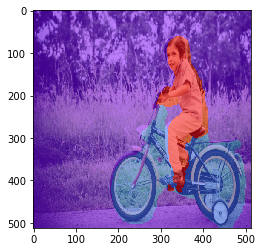

In [32]:
plt.imshow(((x+1)*127.5).astype(np.uint8))
plt.imshow(labels*20,alpha=.5,cmap=plt.cm.rainbow)